In [2]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [10]:
from google.colab import files

uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [16]:
!unzip dataset.zip -d dataset_folder

Archive:  dataset.zip
   creating: dataset_folder/dataset/
   creating: dataset_folder/dataset/cardboard/
  inflating: dataset_folder/dataset/cardboard/cardboard1.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard10.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard100.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard101.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard102.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard103.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard104.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard105.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard106.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard107.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard108.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard109.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboard11.jpg  
  inflating: dataset_folder/dataset/cardboard/cardboa

In [18]:
DATA_DIR = '/content/dataset_folder/dataset'
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
TARGET_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS = 20
SEED = 42

In [19]:
print(f"Loading data from: {DATA_DIR}")

Loading data from: /content/dataset_folder/dataset


In [20]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [21]:
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [22]:
# --- Extract Class Names ---
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(f"Detected classes: {class_names}")

Detected classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [23]:
# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [24]:
# --- Preprocessing and Augmentation ---
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess(image, label):
    image = normalization_layer(image)
    image = data_augmentation(image)
    return image, label

train_ds = train_ds_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
# --- Cache and Prefetch ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
# --- Model Definition (Transfer Learning with EfficientNetV2B2) ---
base_model = tf.keras.applications.EfficientNetV2B2(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# --- Compile the Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Model Summary ---
model.summary()

# --- Callbacks for Training ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('/content/best_model.h5', save_best_only=True, monitor='val_accuracy')
]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,950,500 (34.14 MB)

 Trainable params: 181,126 (707.52 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [28]:
# --- Training the Model ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2149 - loss: 1.7738

64/64 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.2149 - loss: 1.7736 - val_accuracy: 0.2693 - val_loss: 1.7435
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.2120 - loss: 1.7465 - val_accuracy: 0.2436 - val_loss: 1.7331
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.2259 - loss: 1.7423 - val_accuracy: 0.2436 - val_loss: 1.7300
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.2423 - loss: 1.7328 - val_accuracy: 0.2436 - val_loss: 1.7280
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.2331 - loss: 1.7219 - val_accuracy: 0.2436 - val_loss: 1.7283
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.2226 - loss: 1.7251 - val_accuracy: 0.2436 - val_loss: 1.7267
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.2231 - loss: 1.7326 - val_accuracy: 0.2436 - val_loss: 1.7416
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.2339 - loss: 1.7232 - val_accuracy: 0.2436 - val_loss: 1.

64/64 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.2397 - loss: 1.7093 - val_accuracy: 0.2772 - val_loss: 1.7274
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.2536 - loss: 1.7200 - val_accuracy: 0.2752 - val_loss: 1.7211
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.2289 - loss: 1.7247 - val_accuracy: 0.2436 - val_loss: 1.7187
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.2234 - loss: 1.7183 - val_accuracy: 0.2713 - val_loss: 1.7284
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.2655 - loss: 1.7128 - val_accuracy: 0.2436 - val_loss: 1.7135
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.2324 - loss: 1.7282 - val_accuracy: 0.2436 - val_loss: 1.7178
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.2438 - loss: 1.7176 - val_accuracy: 0.2436 - val_loss: 1.7121
Epoch 17/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.2459 - loss: 1.7012 - val_accuracy: 0.2436 - val_l

In [29]:
# --- Fine-Tuning ---
base_model.trainable = True
for layer in base_model.layers[:200]:  # Freeze first 200 layers (EfficientNetV2B2 has more layers)
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Fine-Tune the Model ---
fine_tune_epochs = 10
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + fine_tune_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks
)

Epoch 21/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 349s 5s/step - accuracy: 0.2276 - loss: 1.9572 - val_accuracy: 0.2634 - val_loss: 1.7522
Epoch 22/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2313 - loss: 1.8597

64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.2314 - loss: 1.8594 - val_accuracy: 0.2891 - val_loss: 1.7472
Epoch 23/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - accuracy: 0.2168 - loss: 1.8296 - val_accuracy: 0.2851 - val_loss: 1.7325
Epoch 24/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.2476 - loss: 1.7947 - val_accuracy: 0.2851 - val_loss: 1.7193
Epoch 25/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.2374 - loss: 1.8140 - val_accuracy: 0.2832 - val_loss: 1.7123
Epoch 26/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 310s 5s/step - accuracy: 0.2564 - loss: 1.7554 - val_accuracy: 0.2812 - val_loss: 1.7035
Epoch 27/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 309s 5s/step - accuracy: 0.2277 - loss: 1.7687 - val_accuracy: 0.2851 - val_loss: 1.6908
Epoch 28/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.2441 - loss: 1.7428 - val_accuracy: 0.2812 - val_loss: 1.6766
Epoch 29/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 308s 5s/step - accuracy: 0.2645 - loss: 1.7188 - val_accuracy: 0.2851 - val_l

In [30]:
# --- Evaluation ---
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2889 - loss: 1.6603
Validation Loss: 1.6675
Validation Accuracy: 0.2851


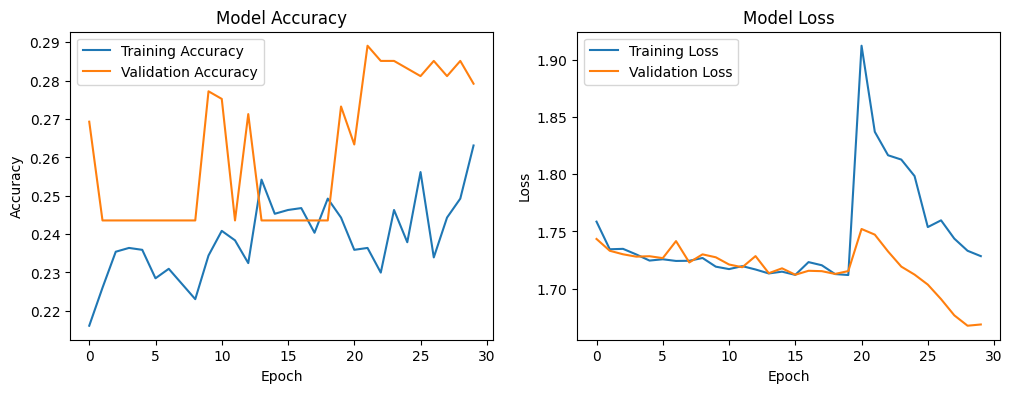

In [31]:
# --- Plot Training History ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()